In [210]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from auxiliary import get_base_network_name
from mpl_settings_v3 import *

net_dir = '../networks/ER'

In [211]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values):

    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        if N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        else:
            dfsMax[N] = dfs1000[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def compute_fc_v2(dfs, min_f, max_f, method='beta'):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

fontsize = 26

### **Estimation of $f_c$**

**First method:**

Assuming the scaling relation

$$
S_i \sim N^{-\beta/\bar{\nu}} \tilde{S}_i\left[(f-f_c) N^{1/\bar{\nu}}\right],
$$

near the critical point we have

$$
S_1 / S_2 \sim \left[(f-f_c) N^{1/\bar{\nu}}\right].
$$

Thus, the curves $S_1 / S_2$ for different sizes should cross at $f=f_c$.

Compute the intersections for each pair of different sizes and average the values

**Second method:**

Define the quantity

$$
B = \dfrac{\langle s \rangle}{S_1^2 N}
$$

Assuming the scalings

$$
\begin{align}
S_1 &\sim N^{-\beta/\bar{\nu}} \tilde{S}_1\left[(f-f_c) N^{1/\bar{\nu}}\right], \\
\langle s \rangle &\sim N^{\gamma/\bar{\nu}} \tilde{s}\left[(f-f_c) N^{1/\bar{\nu}}\right],
\end{align}
$$

as well as the hyperscaling relation 

$$
\dfrac{2\beta}{\bar{\nu}} + \dfrac{\gamma}{\bar{\nu}} = 1,
$$

then $B$ should scale as 

$$
\begin{align}
B &\sim N^{2\beta/\bar{\nu} + \gamma/\bar{\nu} - 1} \tilde{B}\left[(f-f_c) N^{1/\bar{\nu}}\right]\\
B &\sim \tilde{B}\left[(f-f_c) N^{1/\bar{\nu}}\right]
\end{align}
$$

Thus, the curves $B$ for different sizes should cross at $f=f_c$.

Compute the intersections for each pair of different sizes and average the values

In [289]:
def plot_S1_over_S2(dfs1000, dfs10000, dfs20000, dfsMax):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(9*ncols, 6*ncols), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for ax in axes:
        if attack == 'Ran':
            fmin = 0.75
            fmax = 0.87
            fmin = 0.78
            fmax = 0.82
            ax.set_ylim(1, 5)
        if attack == 'Deg':
            fmin = 0.44
            fmax = 0.49
            ax.set_ylim(1.4, 4)
        if attack == 'DegU':
            fmin = 0.334
            fmax = 0.345
            ax.set_ylim(2, 4)
        if attack == 'Btw':
            fmin = 0.52
            fmax = 0.58
            ax.set_ylim(1.3, 1.8)
        ax.set_xlim(fmin, fmax)
        ax.set_ylabel(r'$S_1/S_2$')

    for j, dfs in enumerate([dfs1000, dfs10000, dfs20000, dfsMax]):
        ax = axes[j]

        _N_values = list(dfs.keys())
        for i, N in enumerate(_N_values):

            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
            ax.legend(loc='best', fontsize=20)

    #ax.axvline(0.8, linestyle='--', color='k')

    plt.tight_layout()
    plt.show()

In [213]:
attack = 'Ran'
meank = 5
N_values = [1000, 2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000]      
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)

print('SEEDS = 1000', dfs1000.keys())
print('SEEDS = 10000', dfs10000.keys())
print('SEEDS = 20000', dfs20000.keys())

SEEDS = 1000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000])
SEEDS = 10000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000])
SEEDS = 20000 dict_keys([1000, 2000, 4000, 8000, 16000])


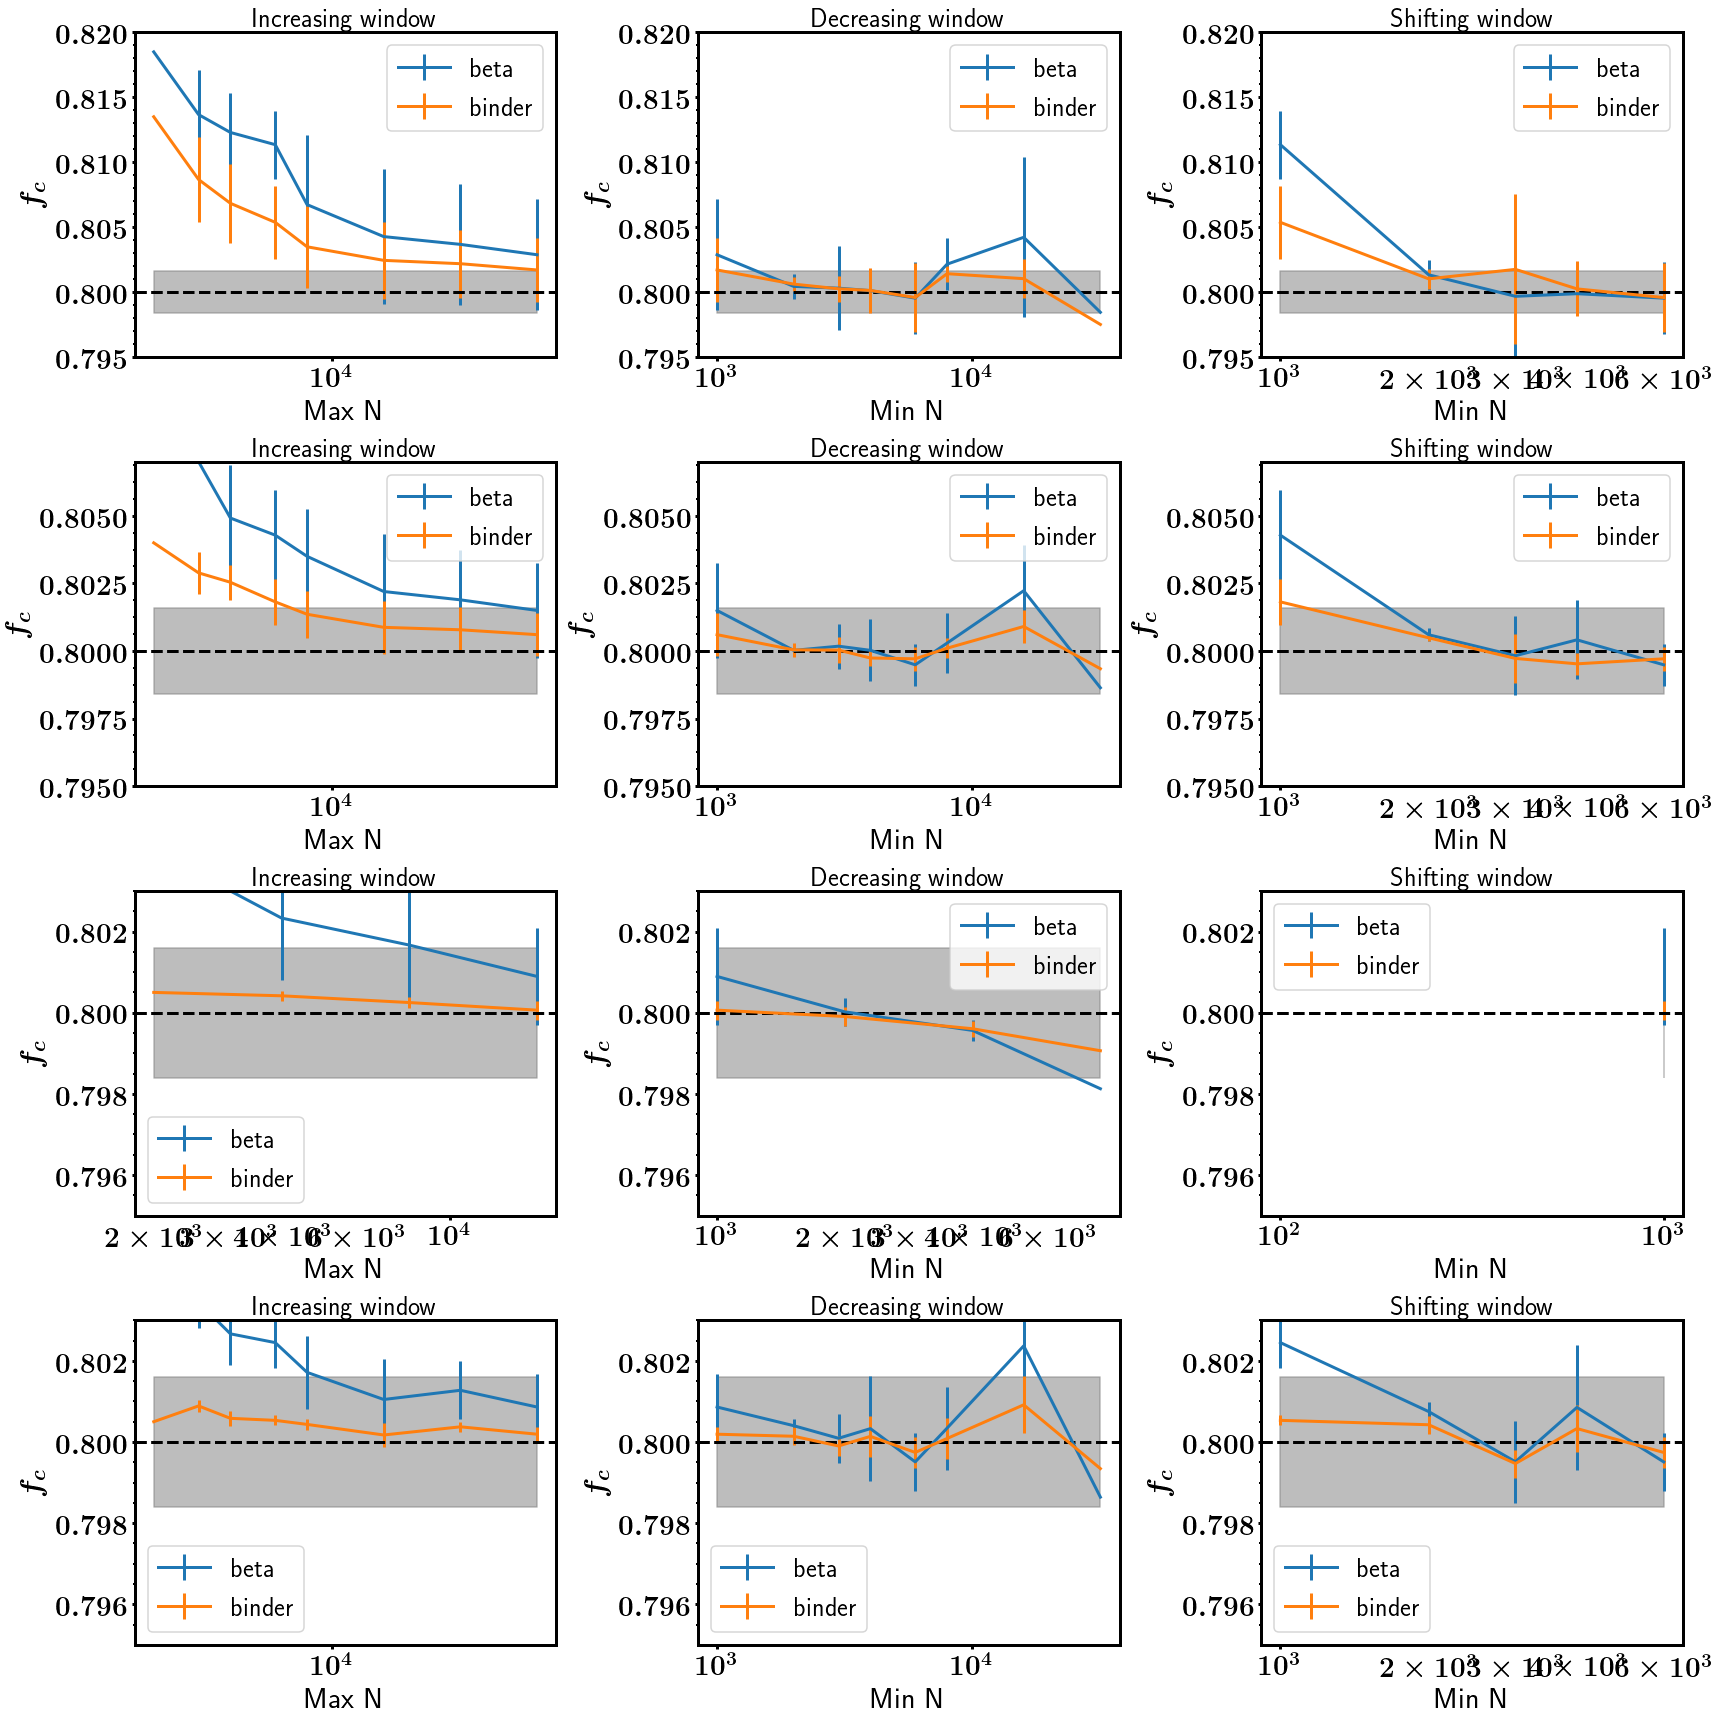

In [214]:
fc_theo = 0.800
tolerance = fc_theo/500
fmin = 0.78
fmax = 0.82

ncols = 3
nrows = 4
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for l in range(nrows):
    
    if l == 0:
        min_f = 0.795
        max_f = 0.82
        _dfs = dfs1000
    elif l == 1:
        min_f = 0.795
        max_f = 0.807
        _dfs = dfs10000
    elif l == 2:
        min_f = 0.795
        max_f = 0.803
        _dfs = dfs20000
    elif l == 3:
        min_f = 0.795
        max_f = 0.803
        _dfs = dfsMax
    _N_values = list(_dfs.keys())
    
    for j, method in enumerate(['beta', 'binder']):

        mean_fc_values = []
        std_fc_values = []
        max_N_values = []
        for i in range(2, len(_N_values)+1):
            keys = _N_values[:i]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            max_N_values.append(N)
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][0]    
        ax.errorbar(max_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(max_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Max N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Increasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        for i in range(len(_N_values)-1):
            keys = _N_values[i:]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][1]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Decreasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        window = 5
        for i in range(len(_N_values)-window+1):
            keys = _N_values[i:i+window]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][2]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Shifting window', fontsize=fontsize)
        ax.legend()

plt.tight_layout()
plt.show()  

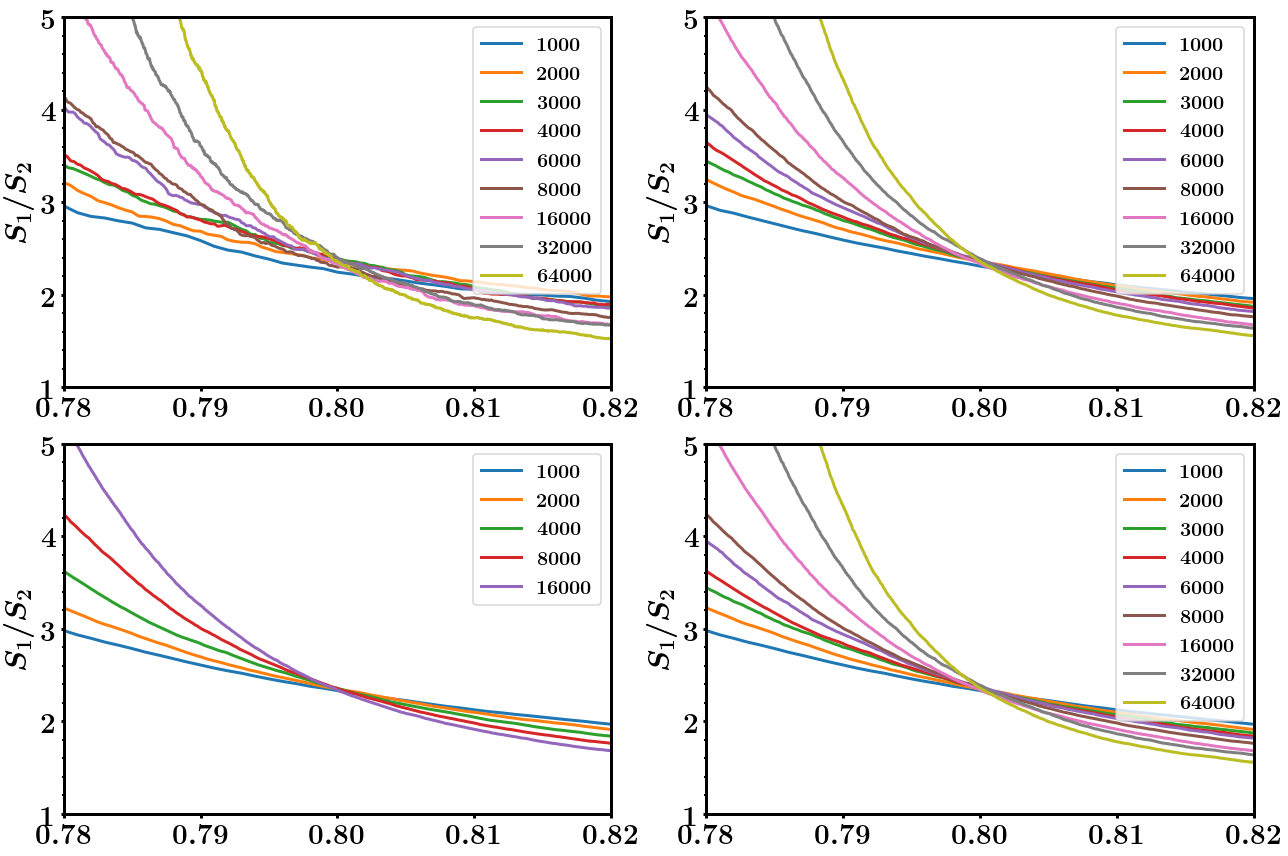

In [215]:
plot_S1_over_S2(dfs1000, dfs10000, dfs20000, dfsMax)

In [273]:
attack = 'Deg'
meank = 5
N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)
        
print('SEEDS = 1000', dfs1000.keys())
print('SEEDS = 10000', dfs10000.keys())
print('SEEDS = 20000', dfs20000.keys())

SEEDS = 1000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000])
SEEDS = 10000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000])
SEEDS = 20000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000])


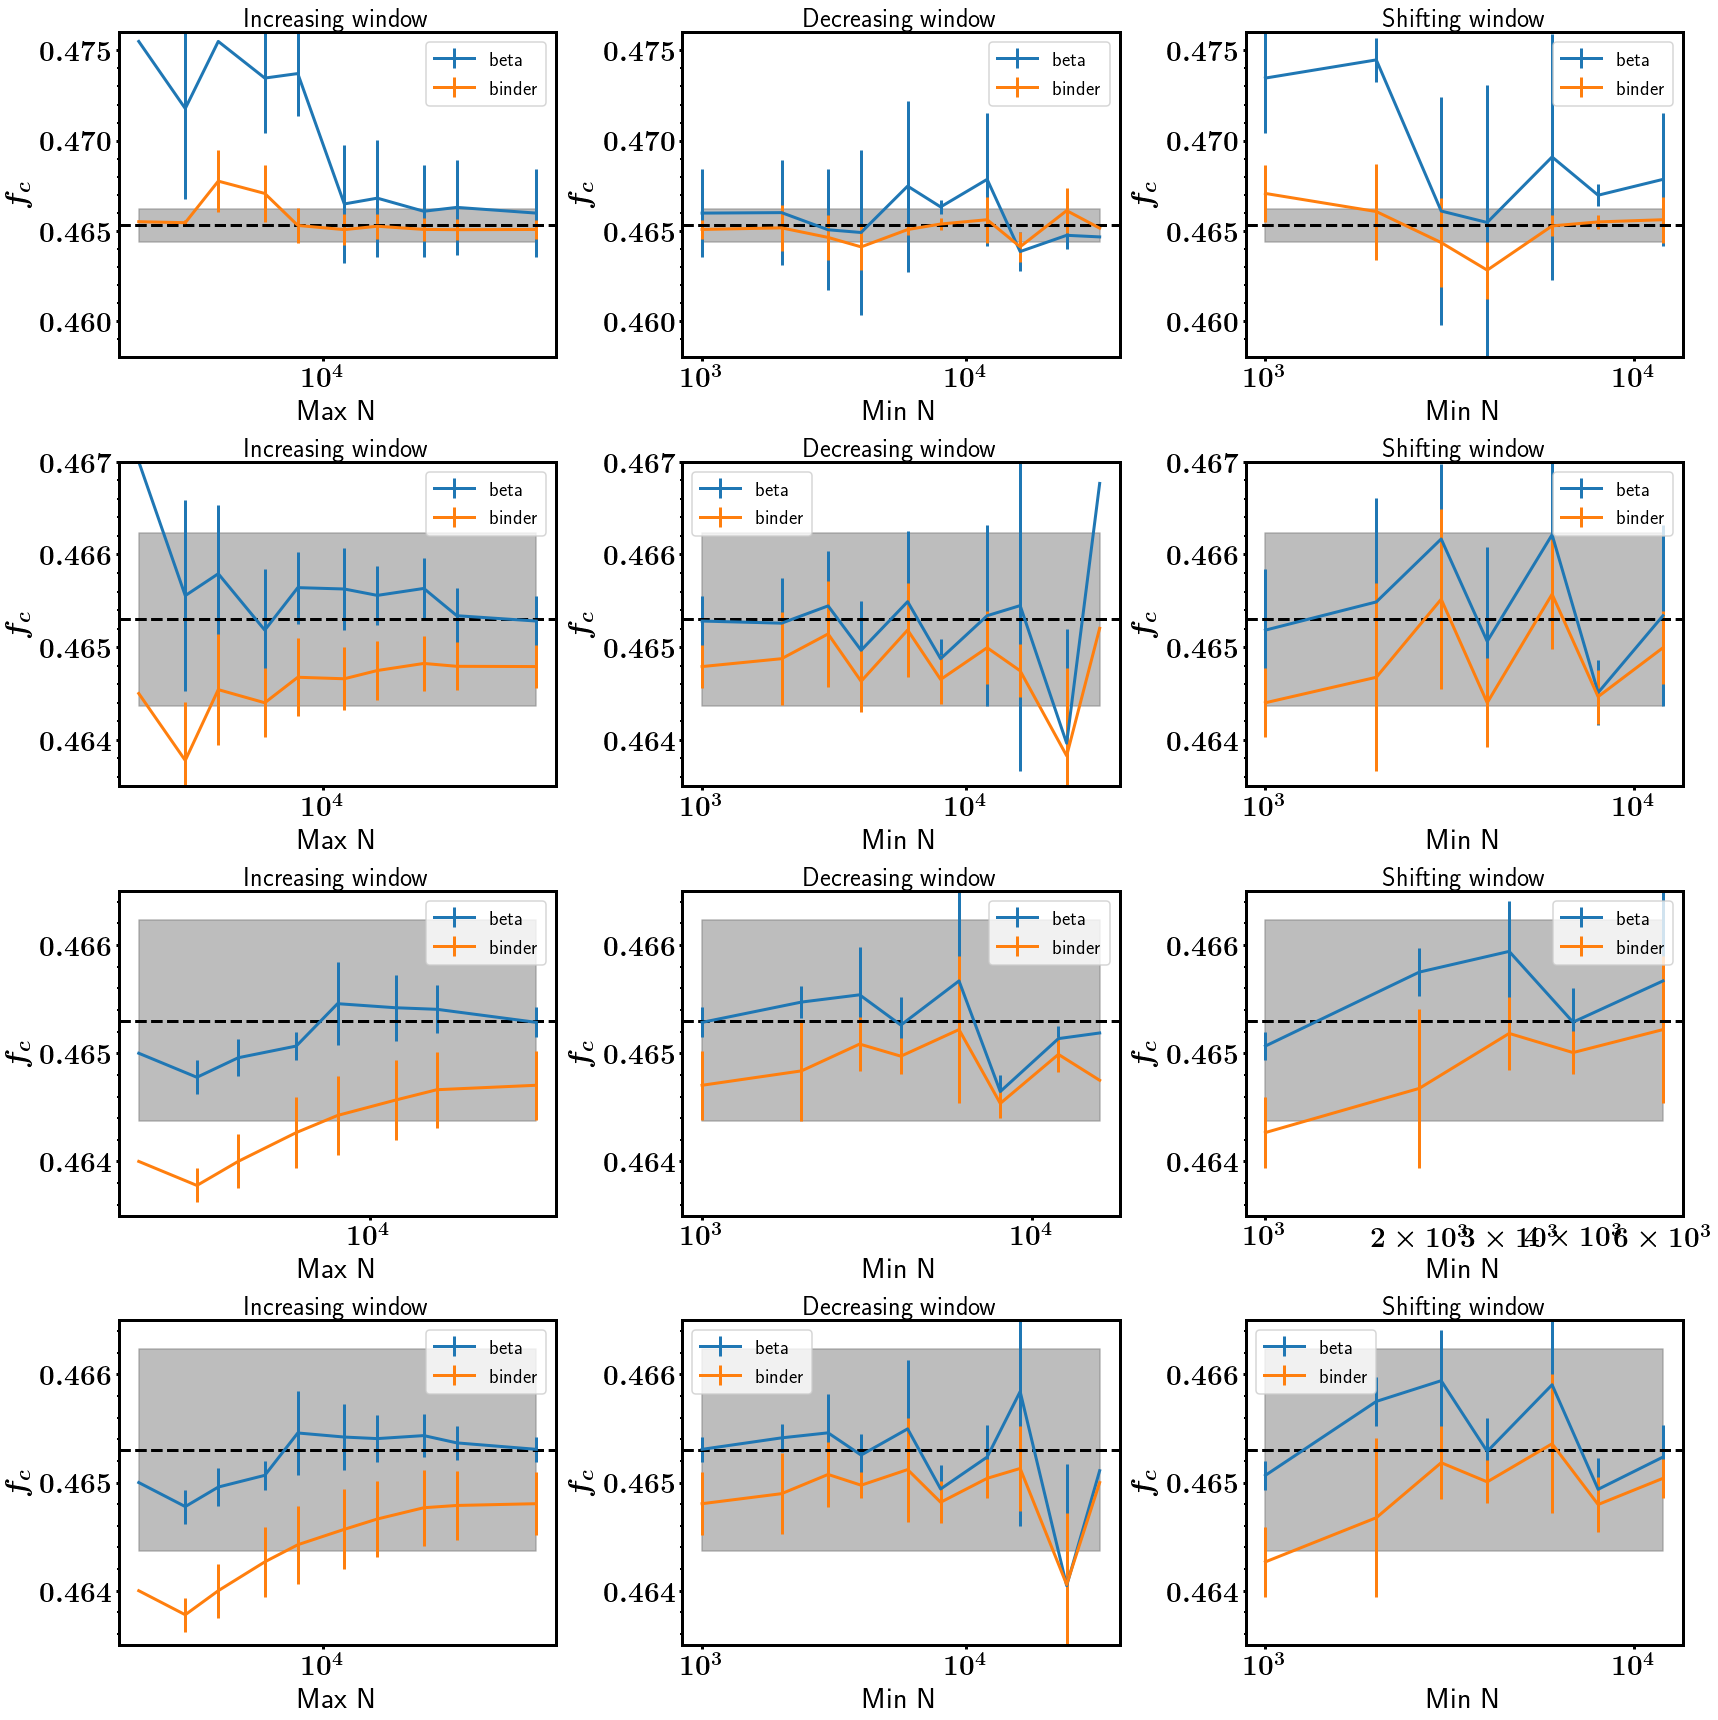

In [274]:
fc_theo = 0.4653
tolerance = fc_theo/500
fmin = 0.44
fmax = 0.49

ncols = 3
nrows = 4
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for l in range(nrows):
    
    if l == 0:
        min_f = 0.458
        max_f = 0.476
        _dfs = dfs1000
    elif l == 1:
        min_f = 0.4635
        max_f = 0.467
        _dfs = dfs10000
    elif l == 2:
        min_f = 0.4635
        max_f = 0.4665
        _dfs = dfs20000
    elif l == 3:
        min_f = 0.4635
        max_f = 0.4665
        _dfs = dfsMax
    _N_values = list(_dfs.keys())
    
    for j, method in enumerate(['beta', 'binder']):

        mean_fc_values = []
        std_fc_values = []
        max_N_values = []
        for i in range(2, len(_N_values)+1):
            keys = _N_values[:i]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            max_N_values.append(N)
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][0]    
        ax.errorbar(max_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(max_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Max N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Increasing window', fontsize=fontsize)
        ax.legend(fontsize=20)

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        for i in range(len(_N_values)-1):
            keys = _N_values[i:]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][1]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Decreasing window', fontsize=fontsize)
        ax.legend(fontsize=20)

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        window = 5
        for i in range(len(_N_values)-window+1):
            keys = _N_values[i:i+window]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][2]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Shifting window', fontsize=fontsize)
        ax.legend(fontsize=20)

plt.tight_layout()
plt.show()  

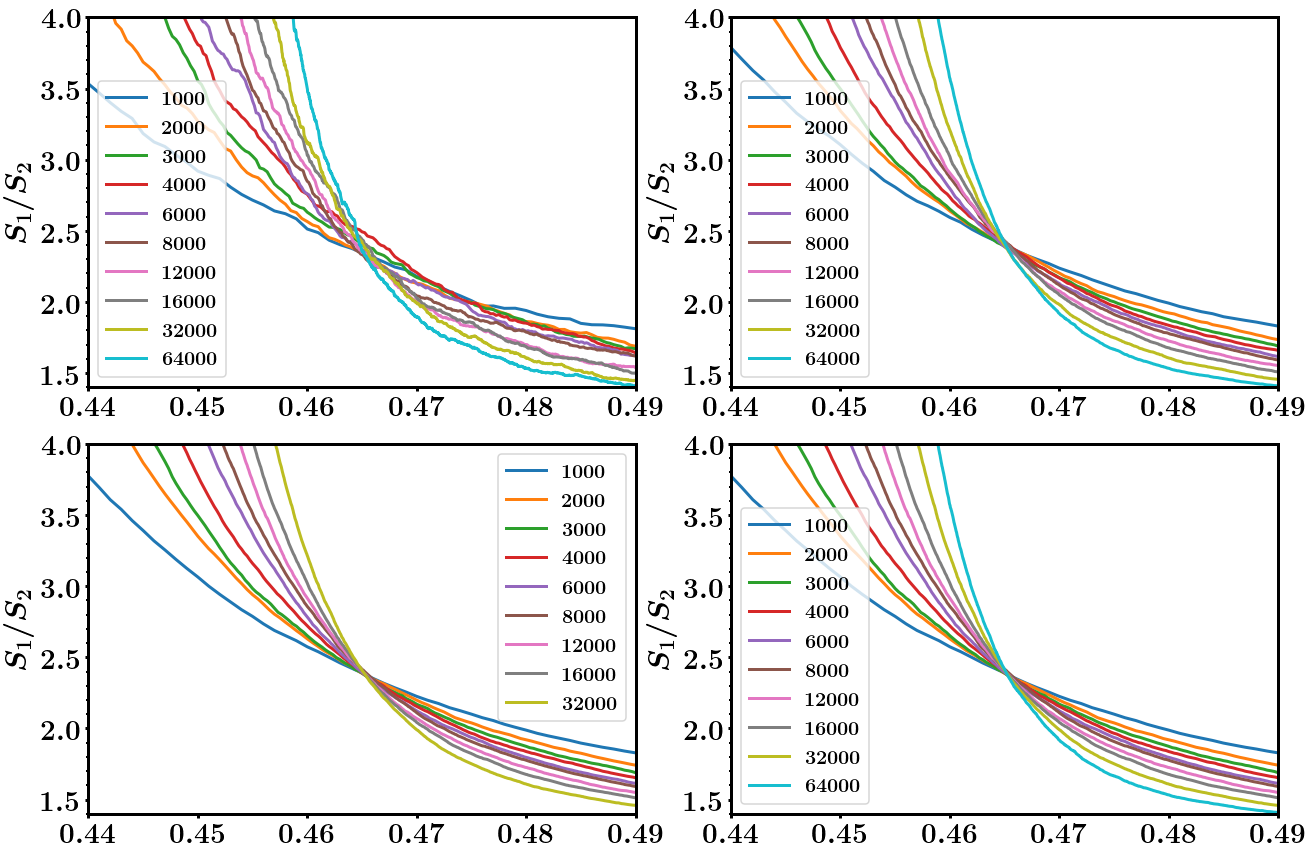

In [265]:
plot_S1_over_S2(dfs1000, dfs10000, dfs20000, dfsMax)

In [297]:
attack = 'DegU'
meank = 5
N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)
        
print('SEEDS = 1000', dfs1000.keys())
print('SEEDS = 10000', dfs10000.keys())
print('SEEDS = 20000', dfs20000.keys())

SEEDS = 1000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000])
SEEDS = 10000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000])
SEEDS = 20000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000])


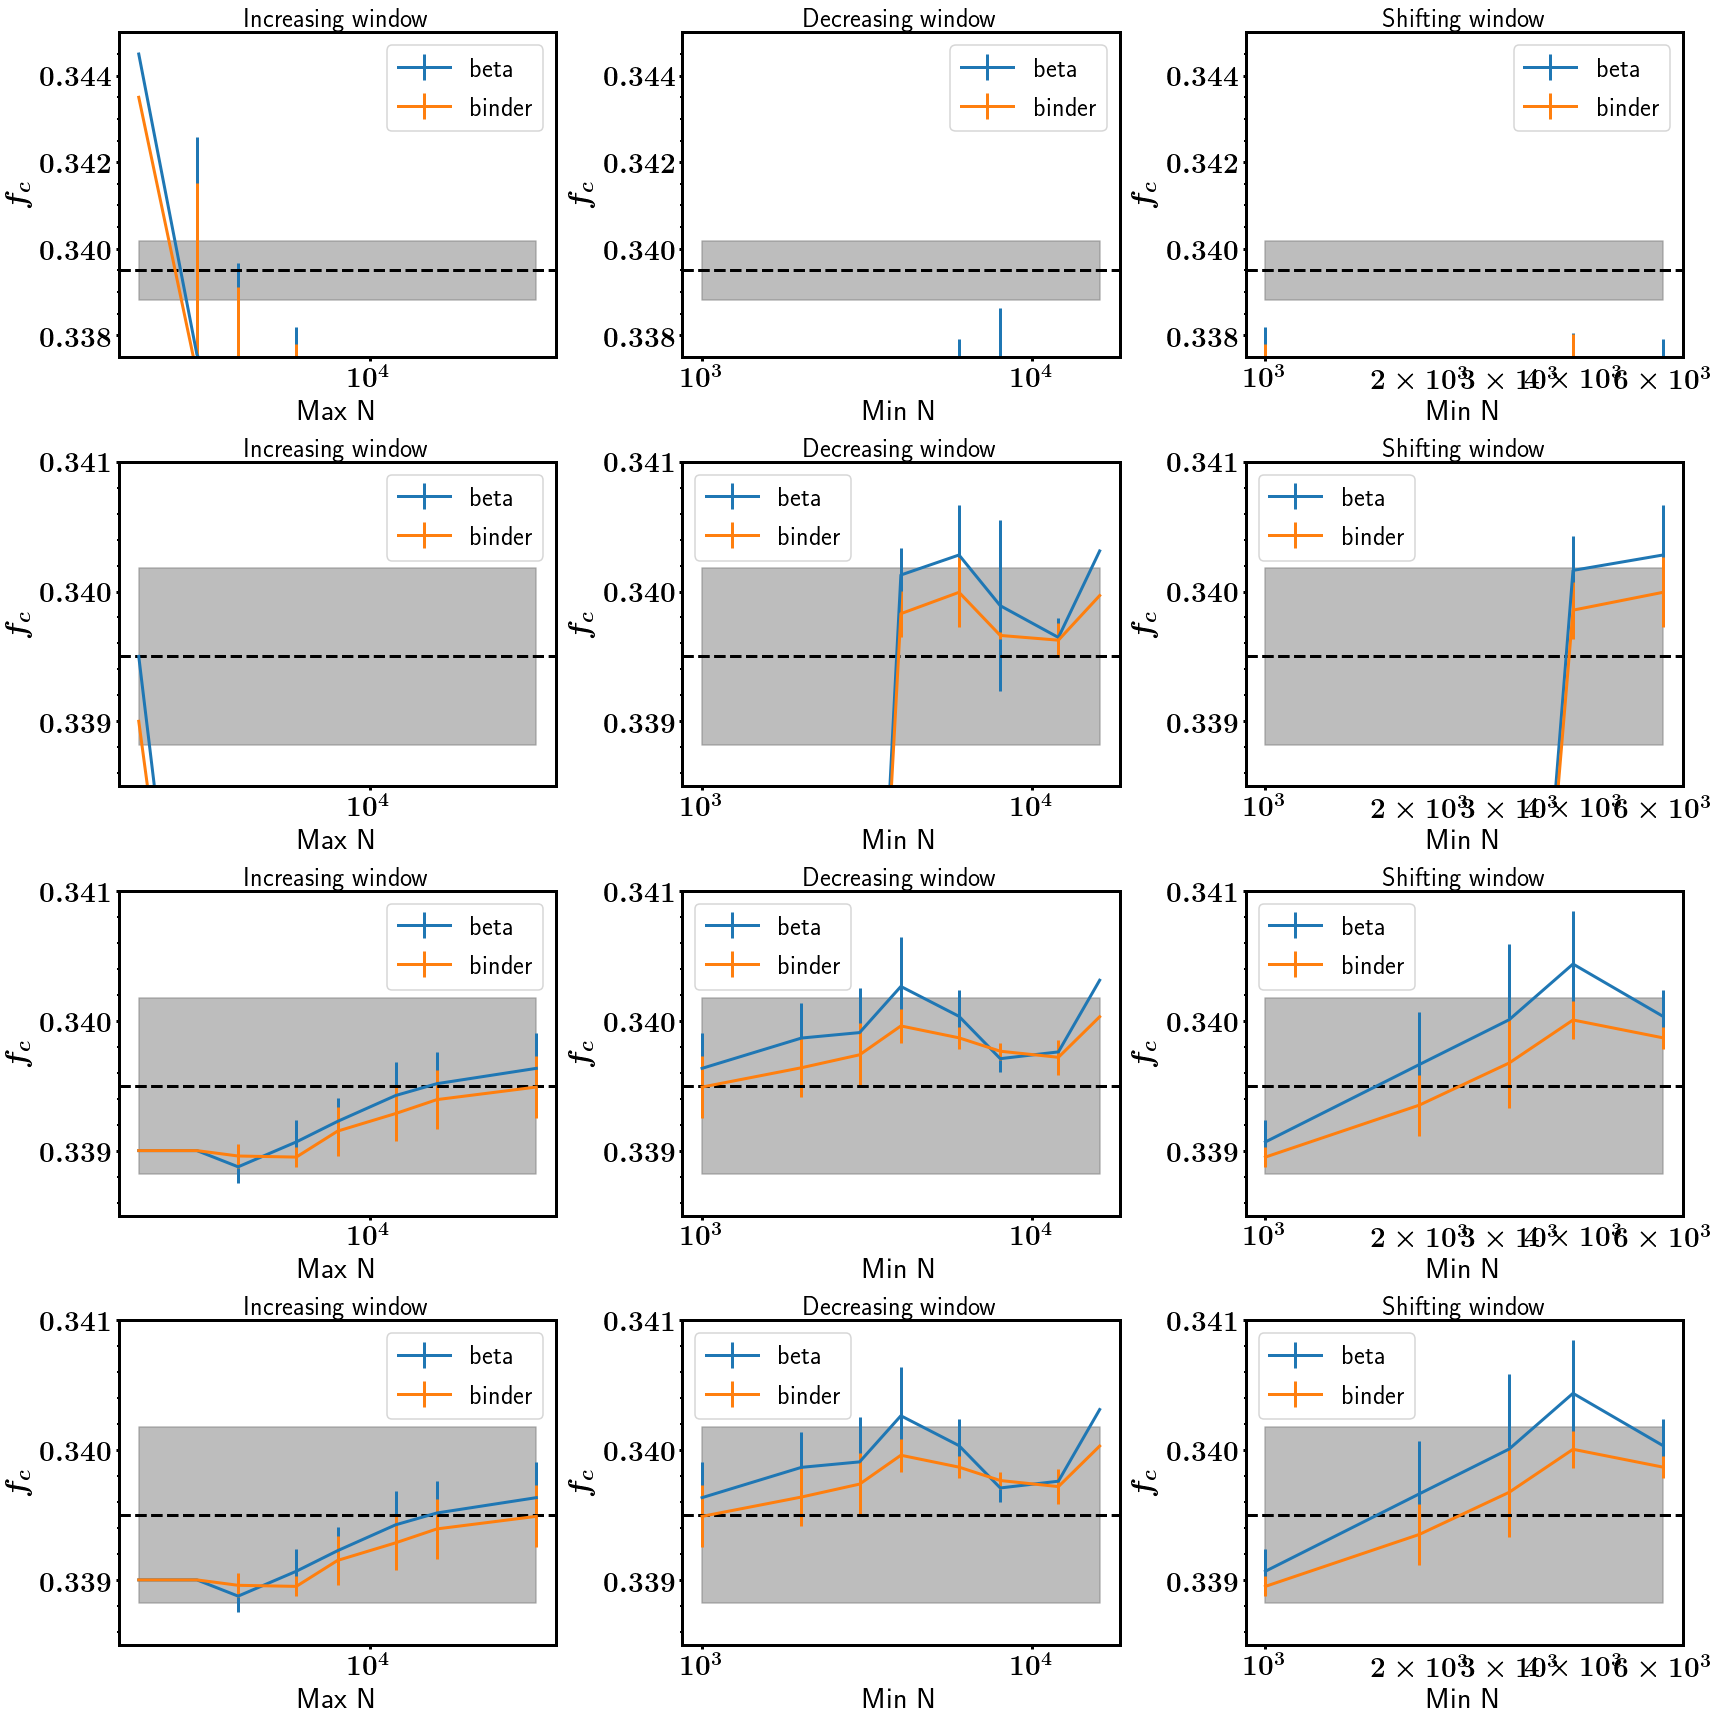

In [298]:
fc_theo = 0.3395
tolerance = fc_theo/500
fmin = 0.334
fmax = 0.345

ncols = 3
nrows = 4
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for l in range(nrows):
    
    if l == 0:
        min_f = 0.3375
        max_f = 0.345
        _dfs = dfs1000
    elif l == 1:
        min_f = 0.3385
        max_f = 0.341
        _dfs = dfs10000
    elif l == 2:
        min_f = 0.3385
        max_f = 0.341
        _dfs = dfs20000
    elif l == 3:
        min_f = 0.3385
        max_f = 0.341
        _dfs = dfsMax
    _N_values = list(_dfs.keys())
    
    for j, method in enumerate(['beta', 'binder']):

        mean_fc_values = []
        std_fc_values = []
        max_N_values = []
        for i in range(2, len(_N_values)+1):
            keys = _N_values[:i]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            max_N_values.append(N)
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][0]    
        ax.errorbar(max_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(max_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Max N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Increasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        for i in range(len(_N_values)-1):
            keys = _N_values[i:]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][1]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Decreasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        window = 5
        for i in range(len(_N_values)-window+1):
            keys = _N_values[i:i+window]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][2]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Shifting window', fontsize=fontsize)
        ax.legend()

plt.tight_layout()
plt.show()  

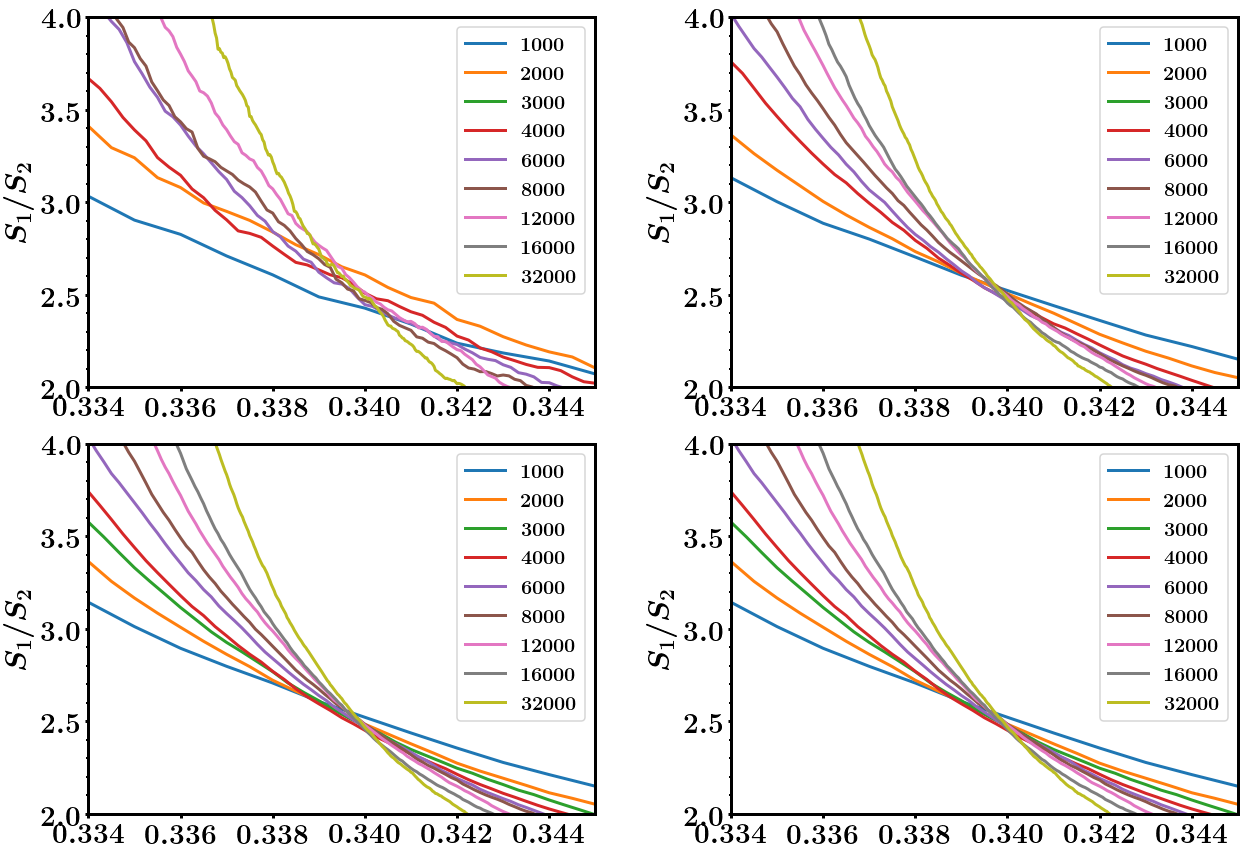

In [299]:
plot_S1_over_S2(dfs1000, dfs10000, dfs20000, dfsMax)

In [294]:
attack = 'Btw'
N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)
        
print('SEEDS = 1000', dfs1000.keys())
print('SEEDS = 10000', dfs10000.keys())
print('SEEDS = 20000', dfs20000.keys())

SEEDS = 1000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000])
SEEDS = 10000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 16000, 32000])
SEEDS = 20000 dict_keys([1000, 2000, 3000, 4000, 6000, 8000, 32000])


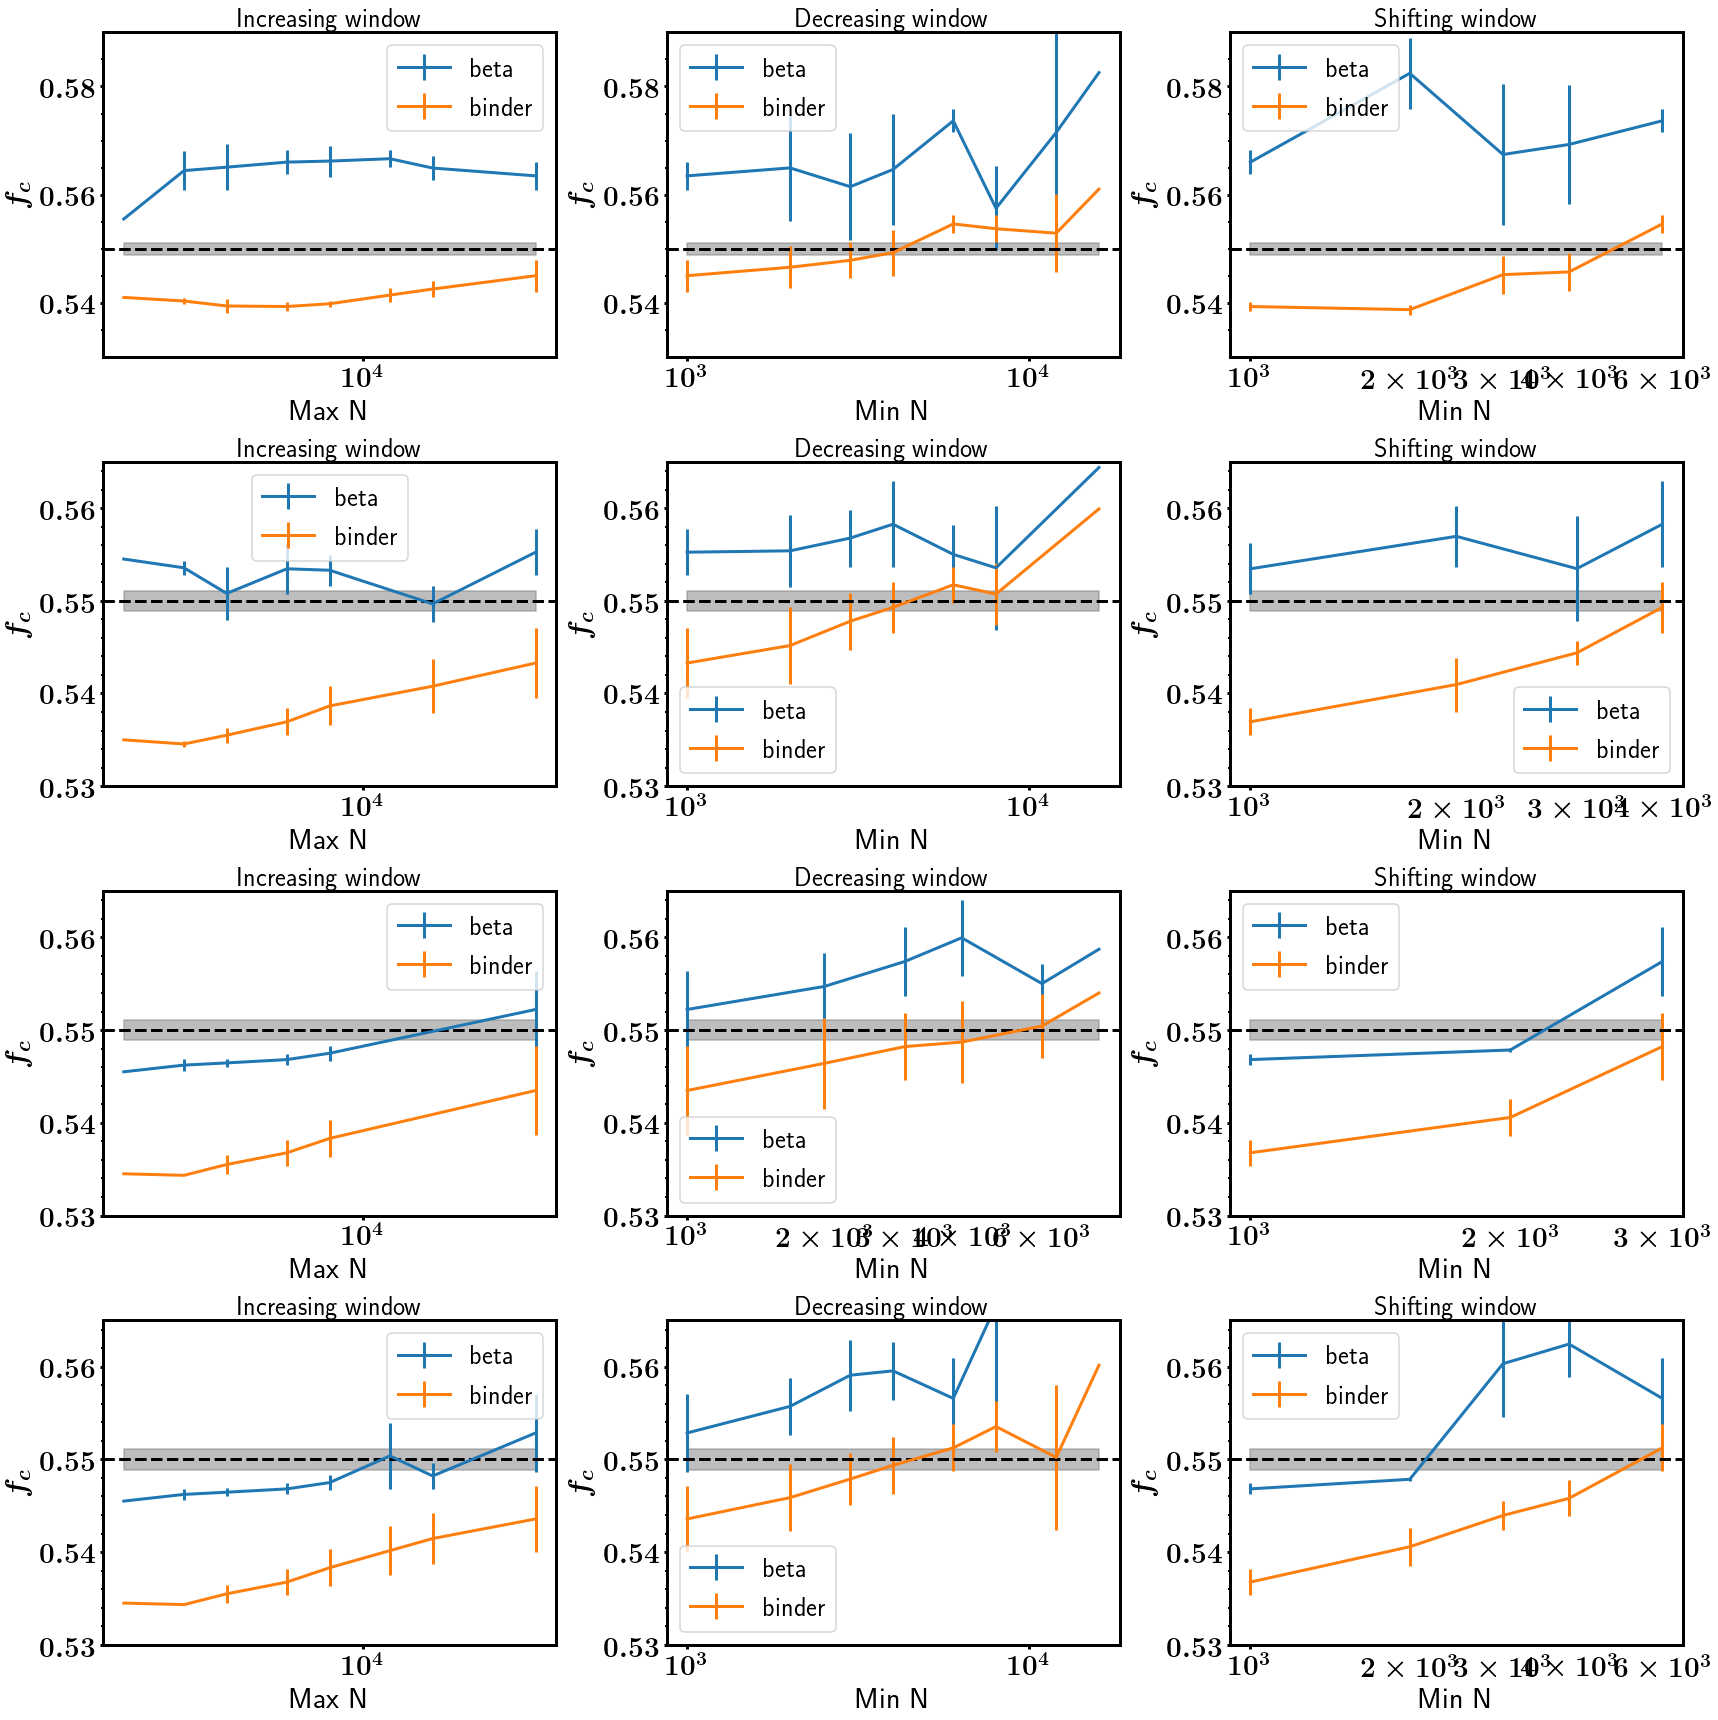

In [295]:
fc_theo = 0.55
tolerance = fc_theo/500
fmin = 0.5
fmax = 0.6

ncols = 3
nrows = 4
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for l in range(nrows):
    
    if l == 0:
        min_f = 0.53
        max_f = 0.59
        _dfs = dfs1000
    elif l == 1:
        min_f = 0.53
        max_f = 0.565
        _dfs = dfs10000
    elif l == 2:
        min_f = 0.53
        max_f = 0.565
        _dfs = dfs20000
    elif l == 3:
        min_f = 0.53
        max_f = 0.565
        _dfs = dfsMax
    _N_values = list(_dfs.keys())
    
    for j, method in enumerate(['beta', 'binder']):

        mean_fc_values = []
        std_fc_values = []
        max_N_values = []
        for i in range(2, len(_N_values)+1):
            keys = _N_values[:i]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            max_N_values.append(N)
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][0]    
        ax.errorbar(max_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(max_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Max N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Increasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        for i in range(len(_N_values)-1):
            keys = _N_values[i:]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][1]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Decreasing window', fontsize=fontsize)
        ax.legend()

        mean_fc_values = []
        std_fc_values = []
        min_N_values = []
        window = 5
        for i in range(len(_N_values)-window+1):
            keys = _N_values[i:i+window]
            dfs = {}
            for N in keys:
                dfs[N] = _dfs[N]
            min_N_values.append(keys[0])
            mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method=method)
            mean_fc_values.append(mean_fc)
            std_fc_values.append(std_fc)
            #print('{:.4f} {:.4f}'.format(mean_fc, std_fc), end='\t')
            #print(keys)

        ax = axes[l][2]
        ax.errorbar(min_N_values, mean_fc_values, std_fc_values, label=method)
        ax.axhline(fc_theo, linestyle='--', color='k')
        ax.fill_between(min_N_values, fc_theo-tolerance, fc_theo+tolerance, color='grey', alpha=0.3)
        ax.set_xscale('log')
        ax.set_ylabel(r'$f_c$')
        ax.set_xlabel('Min N')
        ax.set_ylim(min_f, max_f)
        ax.set_title('Shifting window', fontsize=fontsize)
        ax.legend()

plt.tight_layout()
plt.show()  

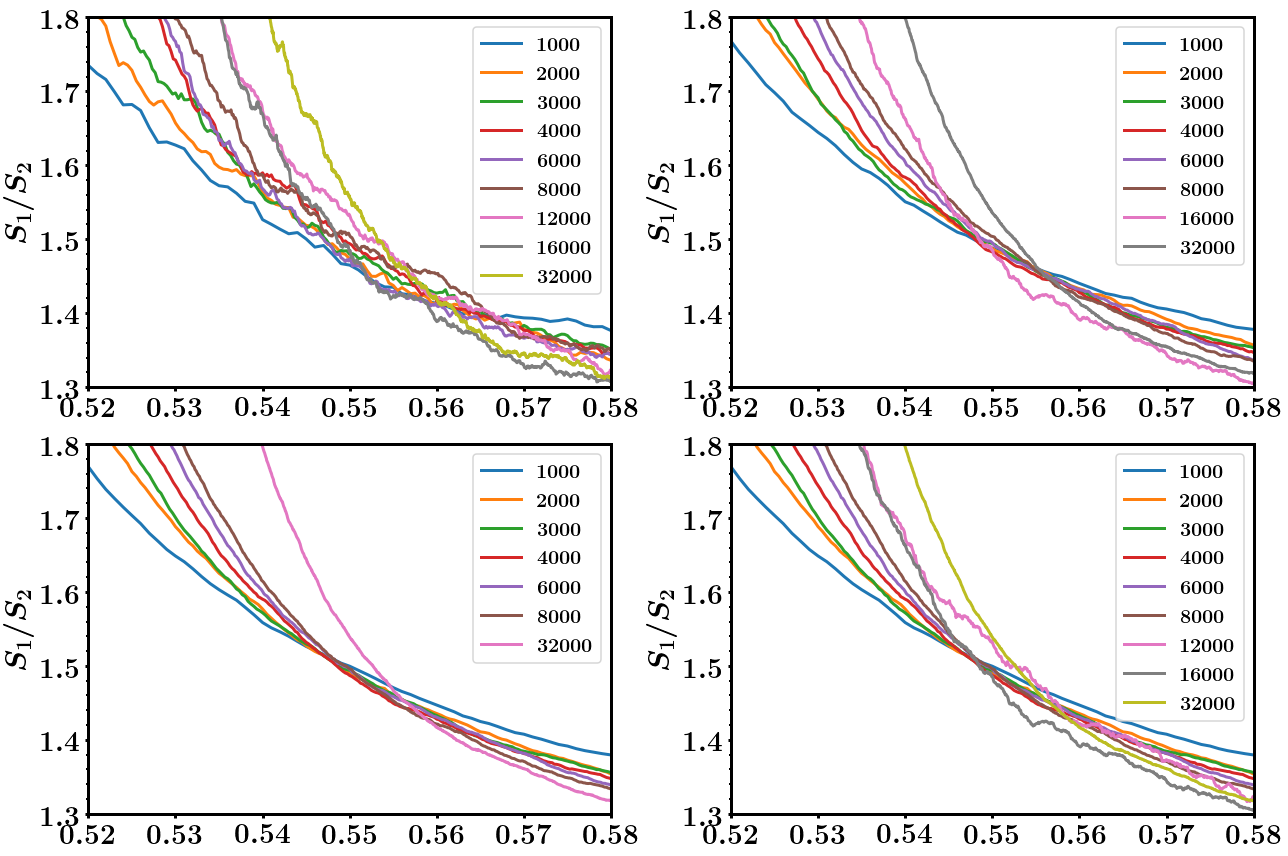

In [296]:
plot_S1_over_S2(dfs1000, dfs10000, dfs20000, dfsMax)

0.4655693181818182


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


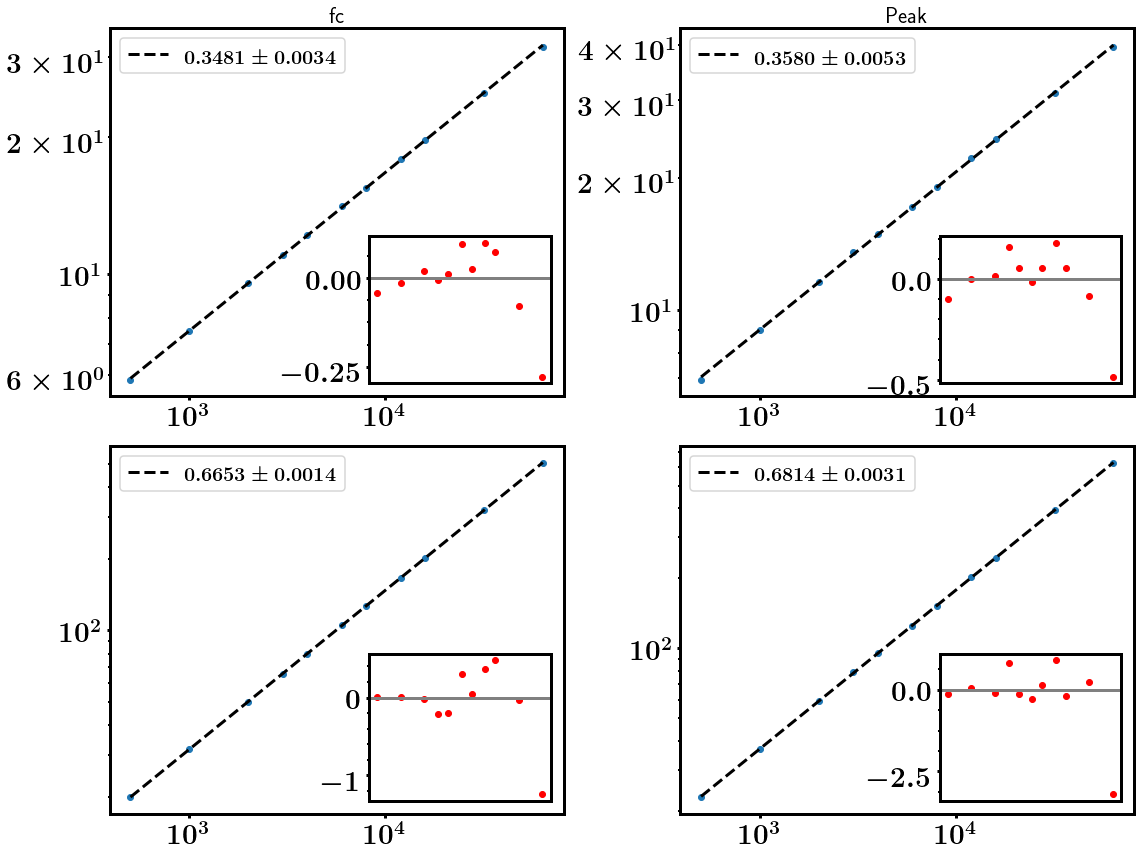

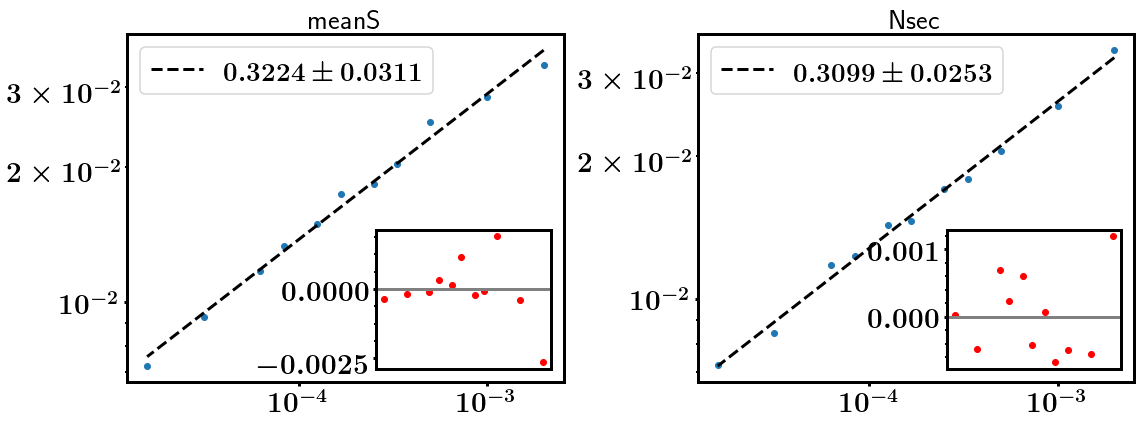

In [272]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

meank = 5

attack = 'Deg'

if attack == 'Ran':
    N_values = [2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000]
    fc_theo = 0.800
    fmin = 0.78
    fmax = 0.82
elif attack == 'Deg':
    #N_values = [8000, 12000, 16000, 32000, 64000]
    N_values = [500, 1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
    fc_theo = 0.4653
    fmin = 0.44
    fmax = 0.49
elif attack == 'DegU':
    N_values = [500, 1000, 2000, 3000, 4000, 6000, 8000, 12000, 32000]
    fc_theo = 0.3395
    fmin = 0.334
    fmax = 0.345
elif attack == 'Btw':
    N_values = [1000, 2000, 3000, 4000, 6000, 8000, 32000]
    fc_theo = 0.55
    tolerance = fc_theo/500
    fmin = 0.5
    fmax = 0.6
    
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)
dfs = {}
_N_values = N_values
for N in _N_values:
    dfs[N] = dfsMax[N]
N_values = list(dfs.keys())

fc = compute_fc_v2(dfs, fmin, fmax)[0]
#fc = fc_theo
print(fc)

measures = ['meanS', 'Nsec']

ncols = 2
nrows = 2
fig, axes_cols = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=2)

for i, measure in enumerate(measures):

    axes = axes_cols[i]
    
    measure_values = get_critical_measures(dfs, measure, fc)
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[0]
    if i == 0:
        ax.set_title('fc', fontsize=22)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    
    ## Inset
    axins = inset_axes(ax, width='40%', height='40%', loc=4)
    axins.set_xscale('log')
    #axins.set_yscale('log')
    axins.plot(N_values, measure_values - Y_pred, 'o', color='red')
    axins.axhline(0, color='grey')
    axins.set_xticks([])
    
    ax.legend(loc='best', fontsize=20)

    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[1]
    if i == 0:
        ax.set_title('Peak', fontsize=22)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))

    ## Inset
    axins = inset_axes(ax, width='40%', height='40%', loc=4)
    axins.set_xscale('log')
    #axins.set_yscale('log')
    axins.plot(N_values, measure_values - Y_pred, 'o', color='red')
    axins.axhline(0, color='grey')
    axins.set_xticks([])
    
    ax.legend(loc='best', fontsize=20)
        
plt.tight_layout()
plt.show()

one_over_N_values = 1/np.array(N_values)

fig, axes = plt.subplots(figsize=(8*ncols, 6), ncols=ncols)
for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_title(measure, fontsize=28)
    ax.set_xscale('log')
    ax.set_yscale('log')

    fc_values, peak_values = getPeaks(dfs, measure)
    fc_diff = fc - np.array(fc_values)

    ax.plot(one_over_N_values, fc_diff, 'o')
    Y_pred, slope, y_err = getLinearReg(one_over_N_values, fc_diff)
    
    ax.plot(one_over_N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    
    ## Inset
    axins = inset_axes(ax, width='40%', height='40%', loc=4)
    axins.set_xscale('log')
    #axins.set_yscale('log')
    axins.plot(one_over_N_values, fc_diff - Y_pred, 'o', color='red')
    axins.axhline(0, color='grey')
    axins.set_xticks([])
    
    ax.legend()
plt.tight_layout()
plt.show()

In [30]:
measure = 'meanS'
for i, dfs in enumerate([dfs1000, dfs10000, dfs20000]):
    measure_values = get_critical_measures(dfs, measure, fc='peak')
    measure_values_dict = dict(zip(meau))
    for N in N_values:
        if N in dfs:
            print(measure_values)

NameError: name 'meau' is not defined

10000	0.3545 0.0059	[2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000]
20000	0.3584 0.0024	[2000, 4000, 8000, 16000]


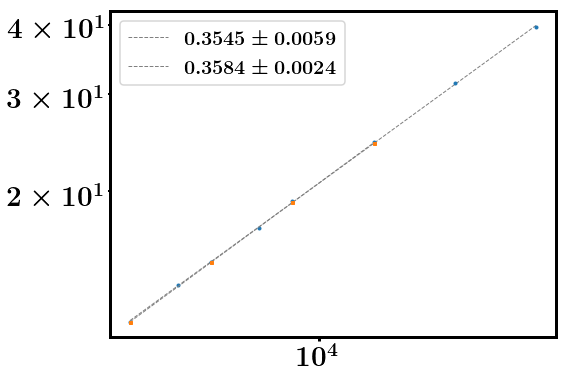

In [40]:
markers = ['o', 's', '^']
n_sim = [1000, 10000, 20000]
n_sim = [10000, 20000]
fig, ax = plt.subplots(figsize=(8, 6))
for i, dfs in enumerate([dfs10000, dfs20000]):
    measure_values = get_critical_measures(dfs, measure, fc='peak')
    
    Y_pred, slope, y_err = getLinearReg(list(dfs.keys()), measure_values)
    print('{}\t{:.4f} {:.4f}'.format(n_sim[i], slope, y_err), end='\t')
    print(list(dfs.keys()))
    ax.plot(dfs.keys(), Y_pred, '--', color='grey', linewidth=1,
            label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.plot(dfs.keys(), measure_values, markers[i], markersize=3)
    ax.legend(loc='best', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [300]:
meank = 5

attack = 'Btw'

if attack == 'Ran':
    N_values = [2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000]
    fc_theo = 0.800
    tolerance = fc_theo/200
    fmin = 0.78
    fmax = 0.82
elif attack == 'Deg':
    N_values = [2000, 3000, 4000, 6000, 8000, 16000, 32000, 64000]
    fc_theo = 0.4653
    tolerance = fc_theo/200
    fmin = 0.44
    fmax = 0.49
elif attack == 'DegU':
    N_values = [1000, 2000, 4000, 8000, 32000]
    fc_theo = 0.3395
    tolerance = fc_theo/200
    fmin = 0.334
    fmax = 0.345

    
dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values)
dfs = {}
_N_values = N_values
for N in _N_values:
    dfs[N] = dfsMax[N]
N_values = list(dfs.keys())

def func(x, a, b, c):
    return a - b*x**c

from scipy.optimize import curve_fit
fc_values, peak_values = getPeaks(dfs, measure)

popt, pcov = curve_fit(func, N_values, fc_values, p0=(fc_theo, 1, -1/3 ))
print(popt)

[ 0.60857689  0.3543455  -0.13605327]


In [301]:
fc_values

[0.47,
 0.483,
 0.48833333333333334,
 0.4945,
 0.501,
 0.504625,
 0.50875,
 0.5130625,
 0.52275]

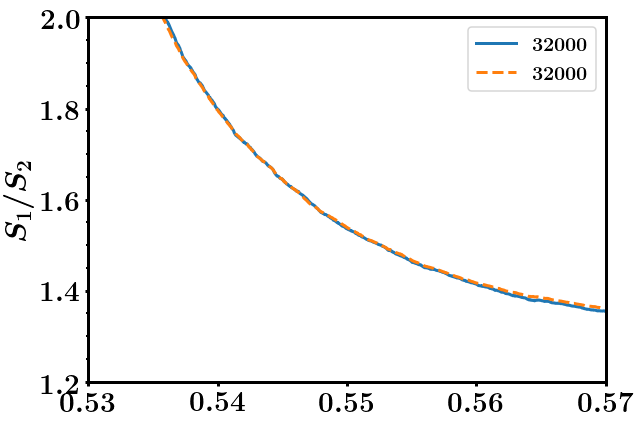

In [305]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(9*ncols, 6*ncols), ncols=ncols, nrows=nrows)

if attack == 'Ran':
    fmin = 0.75
    fmax = 0.87
    fmin = 0.78
    fmax = 0.82
    ax.set_ylim(1, 5)
if attack == 'Deg':
    fmin = 0.44
    fmax = 0.49
    ax.set_ylim(1.4, 4)
if attack == 'DegU':
    fmin = 0.334
    fmax = 0.345
    ax.set_ylim(2, 4)
if attack == 'Btw':
    fmin = 0.53
    fmax = 0.57
    ax.set_ylim(1.2, 2)
ax.set_xlim(fmin, fmax)
ax.set_ylabel(r'$S_1/S_2$')

linestyles = ['-', '--']
for j, dfs in enumerate([dfs10000, dfs20000]):
    _N_values = [32000]
    for i, N in enumerate(_N_values):

        df = dfs[N]
        S1_over_S2 = N * df.Sgcc / df.Nsec
        ax.plot(df.f, S1_over_S2, linestyles[j], label=r'${{{}}}$'.format(N), color=colors[j])
        ax.legend(loc='best', fontsize=20)

#ax.axvline(0.8, linestyle='--', color='k')

plt.tight_layout()
plt.show()

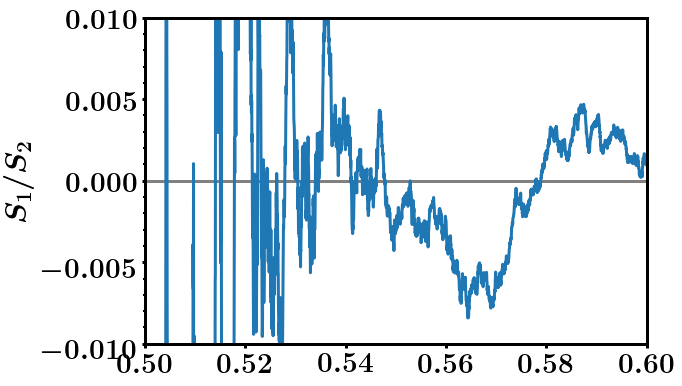

In [262]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(9*ncols, 6*ncols), ncols=ncols, nrows=nrows)

if attack == 'Ran':
    fmin = 0.75
    fmax = 0.87
    fmin = 0.78
    fmax = 0.82
    ax.set_ylim(1, 5)
if attack == 'Deg':
    fmin = 0.44
    fmax = 0.49
    ax.set_ylim(1.4, 4)
if attack == 'DegU':
    fmin = 0.334
    fmax = 0.345
    ax.set_ylim(2, 4)
if attack == 'Btw':
    fmin = 0.5
    fmax = 0.6
    ax.set_ylim(-.01, .01)
ax.set_xlim(fmin, fmax)
ax.set_ylabel(r'$S_1/S_2$')

N = 32000

df = dfs10000[N]
S1_over_S2_10000 = N * df.Sgcc / df.Nsec
df = dfs20000[N]
S1_over_S2_20000 = N * df.Sgcc / df.Nsec
ax.axhline(0, color='grey')
ax.plot(df.f, S1_over_S2_10000 - S1_over_S2_20000, '-')


plt.show()